# Random seed

In [1]:
import random
import numpy as np
import torch


RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

# Load data

In [2]:
from pathlib import Path
from datasets import DatasetDict


dataName = "blanchon/EuroSAT_RGB"
dataPath = Path(dataName)
if dataPath.exists() is False:
    from datasets import load_dataset

    ds: DatasetDict = load_dataset(dataName)  # type: ignore
    ds.save_to_disk(dataPath)  # type: ignore

else:
    from datasets import load_from_disk

    ds: DatasetDict = load_from_disk(dataPath)  # type: ignore

num_classes = len(ds["train"].unique("label"))
print(ds)

/home/tu/micromamba/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 16200
    })
    test: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 5400
    })
    validation: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 5400
    })
})


A look at some images

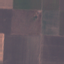

In [3]:
ds["train"][0]["image"]

In [4]:
ds["train"][16199]["label"]

9

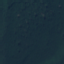

In [5]:
ds["test"][900]["image"]

The properties of the images

In [6]:
img = ds["train"][0]["image"]

print(f"Size = {img.size}")
print(f"Mode = {img.mode}")
print(f"Format = {img.format}")

Size = (64, 64)
Mode = RGB
Format = PNG


# Dataset

Prepare data for training and evaluating.

Also augment the train data by introduce random effects like cropting, rotating, flip.

In [7]:
from torch.utils.data import Dataset
from torchvision.transforms import v2
from torchvision.transforms import functional as ImgF


# ds["train"][0]["image"] is a PIL.JpegImagePlugin.JpegImageFile
class ImageDataset(Dataset):
    """Dataset of images and its labels. Return image and label. If transform is provided, apply it to the image.

    Args:
        Dataset (_type_): _description_
    """

    IMG_SIZE = 64, 64

    def _transformBuild(self):
        transformations = []
        transformations.append(v2.Resize(size=ImageDataset.IMG_SIZE))
        if self.randRot:
            transformations.append(v2.RandomRotation(15))  # type: ignore
        if self.randCrop:
            transformations.append(
                v2.RandomResizedCrop(size=ImageDataset.IMG_SIZE, scale=(0.8, 1.0))
            )
        if self.randFlipH:
            transformations.append(v2.RandomHorizontalFlip())
        if self.randFlipV:
            transformations.append(v2.RandomVerticalFlip())

        transformations.append(v2.ToImage())
        transformations.append(v2.ToDtype(torch.float32, True))

        return v2.Compose(transformations)

    def __init__(
        self,
        data,
        randCrop=False,
        randRot=False,
        randFlipH=False,
        randFlipV=False,
    ):
        self.randCrop = randCrop
        self.randRot = randRot
        self.randFlipH = randFlipH
        self.randFlipV = randFlipV

        self.length = len(data)
        self.imgSize = self.IMG_SIZE

        self.images = [d["image"] for d in data]
        self.labels = [d["label"] for d in data]

        # build the transformer
        self.imgTransformer = self._transformBuild()

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        idx = idx

        return self.imgTransformer(self.images[idx]), self.labels[idx]

# CNN

## DataLoader

In [8]:
from torch.utils.data import DataLoader


BATCH_SIZE = 64


# test if augmentations are overdoing it
trainSet = ImageDataset(ds["train"], True, True, True, True)
valSet = ImageDataset(ds["validation"])
testSet = ImageDataset(ds["test"])

trainLoader = DataLoader(trainSet, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
valLoader = DataLoader(trainSet, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
testLoader = DataLoader(testSet, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

In [9]:
sampleSize = trainSet[0][0].size()
sampleSize

torch.Size([3, 64, 64])

Validate if the image is expected

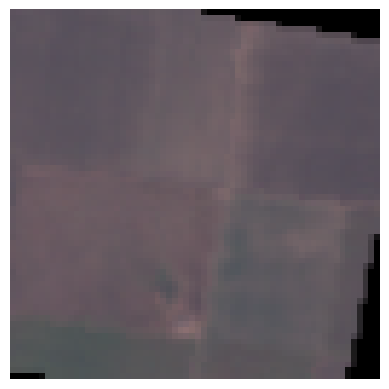

In [10]:
import matplotlib.pyplot as plt

img_np = trainSet[0][0].permute(1, 2, 0).cpu().numpy()
plt.imshow(img_np)
plt.axis("off")
plt.show()

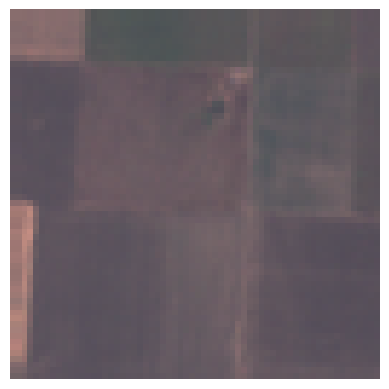

In [11]:
import matplotlib.pyplot as plt

img_np = ds["train"][0]["image"]
plt.imshow(img_np)
plt.axis("off")
plt.show()

## Trainer

In [12]:
def infer(model, device, dataLoader):
    """Infer the predictions.

    Args:
        model (nn.Module): The model to use for inference.
        device (torch.device): The device to use.
        dataLoader (DataLoader): The data to infer.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: The predictions and the actual labels.
    """
    
    
    model.eval()
    predProba = []
    actual = []

    with torch.no_grad():
        for inputs, labels in dataLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            actual.append(labels)
            predProba.append(outputs)

    return torch.cat(predProba), torch.cat(actual)

In [13]:
import copy
from torch.optim.lr_scheduler import ReduceLROnPlateau


def train(
    model,
    device,
    trainLoader,
    valLoader,
    criterion,
    optimizer,
    n_epochs=100,
    earlyStopping=10,
):
    """Train the model.

    Args:
        model (nn.Module): The model to train.
        device (torch.device): The device to use.
        trainLoader (DataLoader): The training data.
        valLoader (DataLoader): The validation data.
        criterion (_type_): The loss function.
        optimizer (_type_): The optimizer.
        n_epochs (int, optional): Number of epochs to train for. Defaults to 100.
        earlyStopping (int, optional): Number of epochs to wait before stopping training if no improvement is made
            on the validation loss. Defaults to 10.
    """

    optimScheduler = ReduceLROnPlateau(optimizer, patience=3, factor=0.2)

    # Training loop
    earlyStopping = 10
    bestValLoss = float("inf")
    bestModelState = None
    patience = 0

    trainLosses = []
    valLosses = []

    for epoch in range(n_epochs):
        trainLoss = 0
        trainAcc = 0
        model.train()

        for batch_idx, (inputs, labels) in enumerate(trainLoader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            acc = (outputs.argmax(dim=1) == labels).float().mean()

            loss.backward()
            optimizer.step()

            trainLoss += loss.item()
            trainAcc += acc.item()

            # Print every 100 batches
            if batch_idx % 100 == 0:
                print(
                    f"Epoch [{epoch+1}/{n_epochs}], Step [{batch_idx}/{len(trainLoader)}], Loss: {loss.item():.4f}, Accuracy: {acc.item():.4f}"
                )

        trainLoss /= len(trainLoader)
        trainAcc /= len(trainLoader)
        trainLosses.append(trainLoss)

        # Validation loss
        pred, actual = infer(model, device, valLoader)
        valLoss = criterion(pred, actual)
        valAcc = (torch.argmax(pred, dim=1) == actual).float().mean()

        valLosses.append(valLoss)

        print(
            f"Epoch [{epoch+1}/{n_epochs}], Train Loss: {trainLoss:.4f}, Val Loss: {valLoss:.4f}, Train Acc: {trainAcc:.4f}, Val Acc: {valAcc:.4f}"
        )
        print("=" * 50)

        # Early stopping
        if valLoss < bestValLoss:
            bestValLoss = valLoss
            bestModelState = copy.deepcopy(model.state_dict())
            patience = 0
        else:
            patience += 1
            if patience > earlyStopping:
                break

        optimScheduler.step(valLoss)

    # Save the model
    # torch.save(bestModelState, "model.pth")
    model.load_state_dict(bestModelState)  # type: ignore
    
    return trainLosses, valLosses

## Model

In [14]:
from torch import nn
from torch.nn import functional as F


class ConvBlock(nn.Module):
    """Convolutional block with Conv2d, BatchNorm2d and activation function."""
    
    def __init__(
        self, in_chn, out_chn, activation, kernel_size=3, alpha=1, stride=1, group=1
    ):
        super().__init__()

        padding = (kernel_size - 1) // 2  # for same padding
        self.conv = nn.Conv2d(
            in_chn,
            out_chn,
            kernel_size,
            stride=stride,
            padding=padding,
            bias=False,
            groups=group,
        )
        self.bn = nn.BatchNorm2d(out_chn)
        self.activate = activation() if activation else None

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.activate is not None:
            x = self.activate(x)
        return x

In [15]:
class SqueezeAndExcite(nn.Module):
    
    
    def __init__(self, in_chn, reduction=4):
        super().__init__()
        reduction_chn = in_chn // reduction
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(
                1
            ),  # 1,16,x,y->1,1,16,1 each channel is reduce to one value
            nn.Flatten(),  #  1,16
            nn.Linear(in_chn, reduction_chn, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(reduction_chn, in_chn, bias=False),
            nn.Hardsigmoid(),
            nn.Unflatten(1, (in_chn, 1, 1)),
        )

    def forward(self, x):
        return x * self.se(x)

In [16]:
class BottleNeck(nn.Module):
    def __init__(
        self,
        in_chn,
        out_chn,
        expansion_channel,
        activation,
        se_reduction=4,
        se_flag=False,
        kernel=3,
        stride=1,
    ):
        super().__init__()
        #         expansion_channel=int(in_chn*expansiton_factor)
        self.use_residual = (stride == 1) and (in_chn == out_chn)

        self.residual_block_layers: list[nn.Module] = [
            ConvBlock(
                in_chn, expansion_channel, activation=activation, kernel_size=1
            ),  # expansion_part
            ConvBlock(
                expansion_channel,
                expansion_channel,
                activation=activation,
                group=expansion_channel,
                stride=stride,
                kernel_size=kernel,
            ),  # depthwise conv
        ]

        if se_flag is True:
            self.residual_block_layers.extend(
                [SqueezeAndExcite(expansion_channel, reduction=se_reduction)]
            )

        self.residual_block_layers.extend(
            [ConvBlock(expansion_channel, out_chn, activation=None, kernel_size=1)]
        )

        self.layers = nn.Sequential(*self.residual_block_layers)

    def forward(self, x):
        return self.layers(x) + x if self.use_residual else self.layers(x)

In [17]:
from torch.nn import Hardswish, ReLU


class MobileNetV3(nn.Module):

    def __init__(
        self,
        in_chn,
        se_reduction=4,
        mode="small",
        num_classes=10,
        bn_eps=0.001,
        bn_momentum=0.01,
    ):
        super().__init__()

        if mode == "large":
            layers_config = [
                # kernel, exp, out, SE, NL, stride
                [3, 16, 16, False, ReLU, 1],
                [3, 64, 24, False, ReLU, 2],
                [3, 72, 24, False, ReLU, 1],
                [5, 72, 40, True, ReLU, 2],
                [5, 120, 40, True, ReLU, 1],
                [5, 120, 40, True, ReLU, 1],
                [3, 240, 80, False, Hardswish, 2],
                [3, 200, 80, False, Hardswish, 1],
                [3, 184, 80, False, Hardswish, 1],
                [3, 184, 80, False, Hardswish, 1],
                [3, 480, 112, True, Hardswish, 1],
                [3, 672, 112, True, Hardswish, 1],
                [5, 672, 160, True, Hardswish, 2],
                [5, 960, 160, True, Hardswish, 1],
                [5, 960, 160, True, Hardswish, 1],
            ]
            last_channel = 1280

            self.final_layers = [
                ConvBlock(
                    layers_config[-1][2], 960, activation=Hardswish, kernel_size=1
                ),
                nn.AdaptiveAvgPool2d(1),
                nn.Conv2d(960, last_channel, 1),
                Hardswish(),
                nn.Flatten(),
                nn.Linear(last_channel, num_classes),
            ]

        else:
            # MobileNetV3-Small
            layers_config = [
                [3, 16, 16, True, ReLU, 2],
                [3, 72, 24, False, ReLU, 2],
                [3, 88, 24, False, ReLU, 1],
                [5, 96, 40, True, Hardswish, 2],
                [5, 240, 40, True, Hardswish, 1],
                [5, 240, 40, True, Hardswish, 1],
                [5, 120, 48, True, Hardswish, 1],
                [5, 144, 48, True, Hardswish, 1],
                [5, 288, 96, True, Hardswish, 2],
                [5, 576, 96, True, Hardswish, 1],
                [5, 576, 96, True, Hardswish, 1],
            ]
            last_channel = 1280
            # final layer
            self.final_layers = [
                ConvBlock(
                    layers_config[-1][2], 576, activation=Hardswish, kernel_size=1
                ),
                SqueezeAndExcite(576, se_reduction),
                nn.AdaptiveAvgPool2d(1),
                nn.Conv2d(576, last_channel, 1),
                Hardswish(),
                nn.Flatten(),
                nn.Linear(last_channel, num_classes),
            ]

        # Initial layers
        self.features: list[nn.Module] = [
            ConvBlock(in_chn, 16, activation=Hardswish, kernel_size=3, stride=2)
        ]
        #         print(dir(self.features[-1]))

        # Build main blocks

        input_channel = 16
        for kernel, exp, out, se, act, stride in layers_config:
            self.features.append(
                BottleNeck(
                    in_chn=input_channel,
                    out_chn=out,
                    expansion_channel=exp,
                    activation=act,
                    kernel=kernel,
                    se_flag=se,
                    stride=stride,
                )
            )
            input_channel = out

        self.start = nn.Sequential(*self.features)
        self.final = nn.Sequential(*self.final_layers)
        
        # modify batchnorm layers
        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eps = bn_eps
                m.momentum = bn_momentum

    def forward(self, x):
        x = self.start(x)
        x = self.final(x)
        return x

## Training

### Config

In [2]:
import torch
lr = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device = ", device)
n_epochs = 100
earlyStopping = 10

Device =  cuda


### Underfitting 

Due to high learning rate

In [ ]:
%%time
import torch.optim as optim


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = MobileNetV3(
    in_chn=3,
    num_classes=num_classes,
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)

train(model, device, trainLoader, valLoader, criterion, optimizer, n_epochs, earlyStopping)

Using device: cuda
Epoch [1/100], Step [0/254], Loss: 2.2964, Accuracy: 0.0625
Epoch [1/100], Step [100/254], Loss: 2.2347, Accuracy: 0.2344
Epoch [1/100], Step [200/254], Loss: 1.5120, Accuracy: 0.3594
Epoch [1/100], Train Loss: 3.1375, Val Loss: 5.3135, Train Acc: 0.2870, Val Acc: 0.2299
Epoch [2/100], Step [0/254], Loss: 1.9193, Accuracy: 0.2656
Epoch [2/100], Step [100/254], Loss: 1.7059, Accuracy: 0.3750
Epoch [2/100], Step [200/254], Loss: 1.6379, Accuracy: 0.4375
Epoch [2/100], Train Loss: 1.5862, Val Loss: 6.3246, Train Acc: 0.4315, Val Acc: 0.2241
Epoch [3/100], Step [0/254], Loss: 1.5092, Accuracy: 0.4062
Epoch [3/100], Step [100/254], Loss: 2.0220, Accuracy: 0.2344
Epoch [3/100], Step [200/254], Loss: 2.2077, Accuracy: 0.1875
Epoch [3/100], Train Loss: 1.9332, Val Loss: 6.3059, Train Acc: 0.2825, Val Acc: 0.1114
Epoch [4/100], Step [0/254], Loss: 2.2451, Accuracy: 0.2031
Epoch [4/100], Step [100/254], Loss: 1.9650, Accuracy: 0.2188
Epoch [4/100], Step [200/254], Loss: 2.0492

### Suitable learning rate

In [ ]:
%%time
import torch.optim as optim


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = MobileNetV3(
    in_chn=3,
    num_classes=num_classes,
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train(model, device, trainLoader, valLoader, criterion, optimizer, n_epochs, earlyStopping)

Using device: cuda
Epoch [1/100], Step [0/254], Loss: 2.3072, Accuracy: 0.0938
Epoch [1/100], Step [100/254], Loss: 1.0484, Accuracy: 0.5625
Epoch [1/100], Step [200/254], Loss: 1.0228, Accuracy: 0.5938
Epoch [1/100], Train Loss: 1.2454, Val Loss: 2.6897, Train Acc: 0.5452, Val Acc: 0.0738
Epoch [2/100], Step [0/254], Loss: 0.8372, Accuracy: 0.7344
Epoch [2/100], Step [100/254], Loss: 0.8029, Accuracy: 0.7031
Epoch [2/100], Step [200/254], Loss: 0.8599, Accuracy: 0.7031
Epoch [2/100], Train Loss: 0.8802, Val Loss: 1.8130, Train Acc: 0.6821, Val Acc: 0.4188
Epoch [3/100], Step [0/254], Loss: 0.6136, Accuracy: 0.7656
Epoch [3/100], Step [100/254], Loss: 1.1179, Accuracy: 0.5625
Epoch [3/100], Step [200/254], Loss: 1.0394, Accuracy: 0.5938
Epoch [3/100], Train Loss: 0.7825, Val Loss: 0.9701, Train Acc: 0.7217, Val Acc: 0.6691
Epoch [4/100], Step [0/254], Loss: 0.6884, Accuracy: 0.7656
Epoch [4/100], Step [100/254], Loss: 0.5601, Accuracy: 0.8438
Epoch [4/100], Step [200/254], Loss: 0.7354

In [20]:
%%time
pred, actual = infer(model, device, testLoader)

CPU times: user 27.5 s, sys: 911 ms, total: 28.4 s
Wall time: 3.73 s


In [21]:
# Accuracy
acc = (torch.argmax(pred, dim=1) == actual).float().mean()
print(f"Test Accuracy: {acc.item():.4f}")

Test Accuracy: 0.9209


## Model using GELU instead of hard swish in bottleneck block

In [20]:
from torch.nn import GELU


class MobileNetV3Gelu(nn.Module):

    def __init__(
        self,
        in_chn,
        se_reduction=4,
        mode="small",
        num_classes=10,
        bn_eps=0.001,
        bn_momentum=0.01,
    ):
        super().__init__()

        if mode == "small":
            # MobileNetV3-Small
            layers_config = [
                [3, 16, 16, True, ReLU, 2],
                [3, 72, 24, False, ReLU, 2],
                [3, 88, 24, False, ReLU, 1],
                [5, 96, 40, True, GELU, 2],
                [5, 240, 40, True, GELU, 1],
                [5, 240, 40, True, GELU, 1],
                [5, 120, 48, True, GELU, 1],
                [5, 144, 48, True, GELU, 1],
                [5, 288, 96, True, GELU, 2],
                [5, 576, 96, True, GELU, 1],
                [5, 576, 96, True, GELU, 1],
            ]
            last_channel = 1280
            # final layer
            self.final_layers = [
                ConvBlock(
                    layers_config[-1][2], 576, activation=Hardswish, kernel_size=1
                ),
                SqueezeAndExcite(576, se_reduction),
                nn.AdaptiveAvgPool2d(1),
                nn.Conv2d(576, last_channel, 1),
                Hardswish(),
                nn.Flatten(),
                nn.Linear(last_channel, num_classes),
            ]

        # Initial layers
        self.features: list[nn.Module] = [
            ConvBlock(in_chn, 16, activation=Hardswish, kernel_size=3, stride=2)
        ]
        #         print(dir(self.features[-1]))

        # Build main blocks

        input_channel = 16
        for kernel, exp, out, se, act, stride in layers_config:
            self.features.append(
                BottleNeck(
                    in_chn=input_channel,
                    out_chn=out,
                    expansion_channel=exp,
                    activation=act,
                    kernel=kernel,
                    se_flag=se,
                    stride=stride,
                )
            )
            input_channel = out

        self.start = nn.Sequential(*self.features)
        self.final = nn.Sequential(*self.final_layers)

        # modify batchnorm layers
        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eps = bn_eps
                m.momentum = bn_momentum

    def forward(self, x):
        x = self.start(x)
        x = self.final(x)
        return x

In [ ]:
%%time
import torch.optim as optim


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = MobileNetV3Gelu(
    in_chn=3,
    num_classes=num_classes,
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train(model, device, trainLoader, valLoader, criterion, optimizer, n_epochs, earlyStopping)

Using device: cuda
Epoch [1/100], Step [0/254], Loss: 2.3029, Accuracy: 0.0469
Epoch [1/100], Step [100/254], Loss: 1.0777, Accuracy: 0.5938
Epoch [1/100], Step [200/254], Loss: 0.7113, Accuracy: 0.7344
Epoch [1/100], Train Loss: 1.1523, Val Loss: 2.8583, Train Acc: 0.5842, Val Acc: 0.0738
Epoch [2/100], Step [0/254], Loss: 1.1049, Accuracy: 0.5469
Epoch [2/100], Step [100/254], Loss: 0.7643, Accuracy: 0.7031
Epoch [2/100], Step [200/254], Loss: 0.8792, Accuracy: 0.6719
Epoch [2/100], Train Loss: 0.8528, Val Loss: 1.6611, Train Acc: 0.6964, Val Acc: 0.4459
Epoch [3/100], Step [0/254], Loss: 0.6187, Accuracy: 0.7500
Epoch [3/100], Step [100/254], Loss: 0.5444, Accuracy: 0.8125
Epoch [3/100], Step [200/254], Loss: 0.5530, Accuracy: 0.7812
Epoch [3/100], Train Loss: 0.7244, Val Loss: 0.7937, Train Acc: 0.7435, Val Acc: 0.7225
Epoch [4/100], Step [0/254], Loss: 0.7477, Accuracy: 0.7188
Epoch [4/100], Step [100/254], Loss: 0.6297, Accuracy: 0.7188
Epoch [4/100], Step [200/254], Loss: 0.4061

([1.1523405620901603,
  0.8528436603039269,
  0.7243547123952174,
  0.6624058939105882,
  0.6065422158072314,
  0.5869444091254332,
  0.5196047922757667,
  0.4882235464265966,
  0.46634577637112984,
  0.4597809772322497,
  0.4226906250311634,
  0.40679400208897476,
  0.40730571799625565,
  0.38122993769256147,
  0.3610886536597267,
  0.3513236552418217,
  0.3449224378532312,
  0.32667241016710835,
  0.3304662373298266,
  0.3091287999523906,
  0.3059096384764187,
  0.30573234463653226,
  0.29063769799517836,
  0.28319622640769315,
  0.2244520227564132,
  0.2135209942925868,
  0.21493461653296872,
  0.20475120440594793,
  0.19725297689144536,
  0.1966512026485261,
  0.19234007711368284,
  0.18817698360076102,
  0.19185450356306993,
  0.188143566720129,
  0.18263006295392833,
  0.18654716529656112,
  0.18669561047370978,
  0.18891476594850304,
  0.18456312226439556,
  0.1781245426634165,
  0.17278508139466206,
  0.1562827003562427,
  0.15040491052030577,
  0.15533151549441138,
  0.1610124

In [22]:
%%time
predGelu, actualGelu = infer(model, device, testLoader)

CPU times: user 26.7 s, sys: 966 ms, total: 27.6 s
Wall time: 3.7 s


In [23]:
geluAcc = (torch.argmax(predGelu, dim=1) == actualGelu).float().mean()
print(f"Test Accuracy: {geluAcc.item():.4f}")

Test Accuracy: 0.9439


## Model using ELU instead of hardswish in bottleneck block

In [24]:
from torch.nn import ELU


class MobileNetV3Elu(nn.Module):

    def __init__(
        self,
        in_chn,
        se_reduction=4,
        mode="small",
        num_classes=10,
        bn_eps=0.001,
        bn_momentum=0.01,
    ):
        super().__init__()

        if mode == "small":
            # MobileNetV3-Small
            layers_config = [
                [3, 16, 16, True, ReLU, 2],
                [3, 72, 24, False, ReLU, 2],
                [3, 88, 24, False, ReLU, 1],
                [5, 96, 40, True, ELU, 2],
                [5, 240, 40, True, ELU, 1],
                [5, 240, 40, True, ELU, 1],
                [5, 120, 48, True, ELU, 1],
                [5, 144, 48, True, ELU, 1],
                [5, 288, 96, True, ELU, 2],
                [5, 576, 96, True, ELU, 1],
                [5, 576, 96, True, ELU, 1],
            ]
            last_channel = 1280
            # final layer
            self.final_layers = [
                ConvBlock(
                    layers_config[-1][2], 576, activation=Hardswish, kernel_size=1
                ),
                SqueezeAndExcite(576, se_reduction),
                nn.AdaptiveAvgPool2d(1),
                nn.Conv2d(576, last_channel, 1),
                Hardswish(),
                nn.Flatten(),
                nn.Linear(last_channel, num_classes),
            ]

        # Initial layers
        self.features: list[nn.Module] = [
            ConvBlock(in_chn, 16, activation=Hardswish, kernel_size=3, stride=2)
        ]
        #         print(dir(self.features[-1]))

        # Build main blocks

        input_channel = 16
        for kernel, exp, out, se, act, stride in layers_config:
            self.features.append(
                BottleNeck(
                    in_chn=input_channel,
                    out_chn=out,
                    expansion_channel=exp,
                    activation=act,
                    kernel=kernel,
                    se_flag=se,
                    stride=stride,
                )
            )
            input_channel = out

        self.start = nn.Sequential(*self.features)
        self.final = nn.Sequential(*self.final_layers)

        # modify batchnorm layers
        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eps = bn_eps
                m.momentum = bn_momentum

    def forward(self, x):
        x = self.start(x)
        x = self.final(x)
        return x

In [25]:
%%time
import torch.optim as optim


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = MobileNetV3Elu(
    in_chn=3,
    num_classes=num_classes,
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train(model, device, trainLoader, valLoader, criterion, optimizer, n_epochs, earlyStopping)

Using device: cuda


Epoch [1/100], Step [0/254], Loss: 2.3026, Accuracy: 0.1562
Epoch [1/100], Step [100/254], Loss: 1.0046, Accuracy: 0.5938
Epoch [1/100], Step [200/254], Loss: 0.8198, Accuracy: 0.6875
Epoch [1/100], Train Loss: 1.1276, Val Loss: 3.1147, Train Acc: 0.5912, Val Acc: 0.1106
Epoch [2/100], Step [0/254], Loss: 0.9759, Accuracy: 0.6250
Epoch [2/100], Step [100/254], Loss: 1.4649, Accuracy: 0.5469
Epoch [2/100], Step [200/254], Loss: 1.0314, Accuracy: 0.6406
Epoch [2/100], Train Loss: 0.8356, Val Loss: 1.7087, Train Acc: 0.6992, Val Acc: 0.4824
Epoch [3/100], Step [0/254], Loss: 0.7938, Accuracy: 0.7344
Epoch [3/100], Step [100/254], Loss: 0.6103, Accuracy: 0.7500
Epoch [3/100], Step [200/254], Loss: 0.4519, Accuracy: 0.8281
Epoch [3/100], Train Loss: 0.7434, Val Loss: 1.0834, Train Acc: 0.7379, Val Acc: 0.6596
Epoch [4/100], Step [0/254], Loss: 0.5767, Accuracy: 0.8125
Epoch [4/100], Step [100/254], Loss: 0.9586, Accuracy: 0.7188
Epoch [4/100], Step [200/254], Loss: 0.7311, Accuracy: 0.7656


([1.1276405303497015,
  0.8355774374928061,
  0.7433535173887343,
  0.6692954608657229,
  0.6028224855192065,
  0.5647461573908649,
  0.5212455495722651,
  0.4743181393723788,
  0.45097026387302896,
  0.41794770081916194,
  0.40809714277898235,
  0.3944704887552524,
  0.3776831647425186,
  0.3112283064213794,
  0.300114090077755,
  0.280710178214734,
  0.2751382489314699,
  0.2804053719412154,
  0.2740256746453563,
  0.2653665639988081,
  0.26069572562073157,
  0.2555849635166915,
  0.26115888826490385,
  0.25767784267957283,
  0.25278246625671236,
  0.23992718017007422,
  0.23527461997284663,
  0.2259450173812119,
  0.2260283733036105,
  0.23145089270620364,
  0.2387224342674017,
  0.22182327922521614,
  0.225536120087495,
  0.2179368640494159,
  0.2256453996744212,
  0.22298474796116352,
  0.22325870187909114,
  0.21448368212486815,
  0.21374717787436143,
  0.21357419356469096,
  0.21802236224840008,
  0.20992092940751023,
  0.20918118045848655,
  0.21844068449723908,
  0.21038059693

In [26]:
%%time
predElu, actualElu = infer(model, device, testLoader)

CPU times: user 27.5 s, sys: 967 ms, total: 28.5 s
Wall time: 3.63 s


In [27]:
eluAcc = (torch.argmax(predElu, dim=1) == actualElu).float().mean()
print(f"Test Accuracy: {geluAcc.item():.4f}")

Test Accuracy: 0.9439


## Model using LeakyRelu instead of hardswish in Bottleneck block

In [28]:
from torch.nn import LeakyReLU


class MobileNetV3Leaky(nn.Module):

    def __init__(
        self,
        in_chn,
        se_reduction=4,
        mode="small",
        num_classes=10,
        bn_eps=0.001,
        bn_momentum=0.01,
    ):
        super().__init__()

        if mode == "small":
            # MobileNetV3-Small
            layers_config = [
                [3, 16, 16, True, ReLU, 2],
                [3, 72, 24, False, ReLU, 2],
                [3, 88, 24, False, ReLU, 1],
                [5, 96, 40, True, LeakyReLU, 2],
                [5, 240, 40, True, LeakyReLU, 1],
                [5, 240, 40, True, LeakyReLU, 1],
                [5, 120, 48, True, LeakyReLU, 1],
                [5, 144, 48, True, LeakyReLU, 1],
                [5, 288, 96, True, LeakyReLU, 2],
                [5, 576, 96, True, LeakyReLU, 1],
                [5, 576, 96, True, LeakyReLU, 1],
            ]
            last_channel = 1280
            # final layer
            self.final_layers = [
                ConvBlock(
                    layers_config[-1][2], 576, activation=Hardswish, kernel_size=1
                ),
                SqueezeAndExcite(576, se_reduction),
                nn.AdaptiveAvgPool2d(1),
                nn.Conv2d(576, last_channel, 1),
                Hardswish(),
                nn.Flatten(),
                nn.Linear(last_channel, num_classes),
            ]

        # Initial layers
        self.features: list[nn.Module] = [
            ConvBlock(in_chn, 16, activation=Hardswish, kernel_size=3, stride=2)
        ]
        #         print(dir(self.features[-1]))

        # Build main blocks

        input_channel = 16
        for kernel, exp, out, se, act, stride in layers_config:
            self.features.append(
                BottleNeck(
                    in_chn=input_channel,
                    out_chn=out,
                    expansion_channel=exp,
                    activation=act,
                    kernel=kernel,
                    se_flag=se,
                    stride=stride,
                )
            )
            input_channel = out

        self.start = nn.Sequential(*self.features)
        self.final = nn.Sequential(*self.final_layers)

        # modify batchnorm layers
        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eps = bn_eps
                m.momentum = bn_momentum

    def forward(self, x):
        x = self.start(x)
        x = self.final(x)
        return x

In [29]:
%%time
import torch.optim as optim


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = MobileNetV3Leaky(
    in_chn=3,
    num_classes=num_classes,
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train(model, device, trainLoader, valLoader, criterion, optimizer, n_epochs, earlyStopping)

Using device: cuda


Epoch [1/100], Step [0/254], Loss: 2.3111, Accuracy: 0.0938
Epoch [1/100], Step [100/254], Loss: 1.3709, Accuracy: 0.5312
Epoch [1/100], Step [200/254], Loss: 1.0504, Accuracy: 0.5469
Epoch [1/100], Train Loss: 1.2057, Val Loss: 3.2128, Train Acc: 0.5547, Val Acc: 0.0738
Epoch [2/100], Step [0/254], Loss: 1.0695, Accuracy: 0.6094
Epoch [2/100], Step [100/254], Loss: 0.7829, Accuracy: 0.6719
Epoch [2/100], Step [200/254], Loss: 0.8235, Accuracy: 0.7500
Epoch [2/100], Train Loss: 0.8952, Val Loss: 1.7690, Train Acc: 0.6846, Val Acc: 0.4367
Epoch [3/100], Step [0/254], Loss: 1.0630, Accuracy: 0.6719
Epoch [3/100], Step [100/254], Loss: 0.8378, Accuracy: 0.7344
Epoch [3/100], Step [200/254], Loss: 0.6594, Accuracy: 0.7344
Epoch [3/100], Train Loss: 0.7536, Val Loss: 1.3294, Train Acc: 0.7357, Val Acc: 0.6230
Epoch [4/100], Step [0/254], Loss: 0.6201, Accuracy: 0.8125
Epoch [4/100], Step [100/254], Loss: 0.7240, Accuracy: 0.7500
Epoch [4/100], Step [200/254], Loss: 0.6340, Accuracy: 0.7969


([1.2056729523685035,
  0.895162730705081,
  0.7536280679655826,
  0.6927459298625706,
  0.6114184709749823,
  0.5981067278253751,
  0.5330351925506367,
  0.5200614942692396,
  0.477996087977736,
  0.457701325181901,
  0.4444837455205091,
  0.4092987003758198,
  0.4183402805347142,
  0.39405642344257025,
  0.3893335371857553,
  0.374477186892915,
  0.36461322707688715,
  0.35076466009138135,
  0.3344695196435677,
  0.31863156644495455,
  0.32358062842230156,
  0.3316278682625669,
  0.29842899860007555,
  0.24323792086811516,
  0.2259903264591309,
  0.21919267994212352,
  0.21633716216530857,
  0.21330135246724125,
  0.22382246666243227,
  0.22015280203204454,
  0.20155607059773967,
  0.20470878434932138,
  0.1945146644106648,
  0.19198901816381245,
  0.18227503074729068,
  0.18910906997721966,
  0.18601405010448666,
  0.1779126077890396,
  0.182119106345876,
  0.1773536583394047,
  0.17758769885908196,
  0.1808204355495652,
  0.18418877277024617,
  0.18806795258162998,
  0.168629077915

In [30]:
%%time
predLeaky, actualLeaky = infer(model, device, testLoader)

CPU times: user 25.5 s, sys: 814 ms, total: 26.3 s
Wall time: 3.29 s


In [31]:
predAcc = (torch.argmax(predLeaky, dim=1) == actualLeaky).float().mean()
print(f"Test Accuracy: {predAcc.item():.4f}")

Test Accuracy: 0.9378


## Model using Hard-ELU instead of hardswish in bottleneck block

In [23]:
def hardElu(x, alpha=1.0, inplace=False):
    safe_x = torch.where(x < 0.0, x, torch.zeros_like(x))

    if inplace:
        x[:] = torch.where(x < 0.0, alpha * safe_x / (1 - safe_x), x)
        return x
    else:
        return torch.where(x < 0.0, alpha * safe_x / (1 - safe_x), x)


class HardELU(nn.Module):
    def __init__(self, alpha=1.0, inplace=False):
        super().__init__()
        self.alpha = alpha
        self.inplace = inplace

    def forward(self, x):
        return hardElu(x, self.alpha, self.inplace)


class MobileNetV3HardElu(nn.Module):

    def __init__(
        self,
        in_chn,
        se_reduction=4,
        mode="small",
        num_classes=10,
        bn_eps=0.001,
        bn_momentum=0.01,
    ):
        super().__init__()

        if mode == "small":
            # MobileNetV3-Small
            layers_config = [
                [3, 16, 16, True, ReLU, 2],
                [3, 72, 24, False, ReLU, 2],
                [3, 88, 24, False, ReLU, 1],
                [5, 96, 40, True, HardELU, 2],
                [5, 240, 40, True, HardELU, 1],
                [5, 240, 40, True, HardELU, 1],
                [5, 120, 48, True, HardELU, 1],
                [5, 144, 48, True, HardELU, 1],
                [5, 288, 96, True, HardELU, 2],
                [5, 576, 96, True, HardELU, 1],
                [5, 576, 96, True, HardELU, 1],
            ]
            last_channel = 1280
            # final layer
            self.final_layers = [
                ConvBlock(
                    layers_config[-1][2], 576, activation=Hardswish, kernel_size=1
                ),
                SqueezeAndExcite(576, se_reduction),
                nn.AdaptiveAvgPool2d(1),
                nn.Conv2d(576, last_channel, 1),
                Hardswish(),
                nn.Flatten(),
                nn.Linear(last_channel, num_classes),
            ]

        # Initial layers
        self.features: list[nn.Module] = [
            ConvBlock(in_chn, 16, activation=Hardswish, kernel_size=3, stride=2)
        ]
        #         print(dir(self.features[-1]))

        # Build main blocks

        input_channel = 16
        for kernel, exp, out, se, act, stride in layers_config:
            self.features.append(
                BottleNeck(
                    in_chn=input_channel,
                    out_chn=out,
                    expansion_channel=exp,
                    activation=act,
                    kernel=kernel,
                    se_flag=se,
                    stride=stride,
                )
            )
            input_channel = out

        self.start = nn.Sequential(*self.features)
        self.final = nn.Sequential(*self.final_layers)

        # modify batchnorm layers
        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eps = bn_eps
                m.momentum = bn_momentum

    def forward(self, x):
        x = self.start(x)
        x = self.final(x)
        return x

In [24]:
%%time
import torch.optim as optim


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = MobileNetV3HardElu(
    in_chn=3,
    num_classes=num_classes,
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train(model, device, trainLoader, valLoader, criterion, optimizer, n_epochs, earlyStopping)

Using device: cpu
Epoch [1/100], Step [0/254], Loss: 2.3101, Accuracy: 0.1094
Epoch [1/100], Step [100/254], Loss: 1.0525, Accuracy: 0.5781
Epoch [1/100], Step [200/254], Loss: 0.9817, Accuracy: 0.6562
Epoch [1/100], Train Loss: 1.1655, Val Loss: 2.9838, Train Acc: 0.5738, Val Acc: 0.1106
Epoch [2/100], Step [0/254], Loss: 0.9359, Accuracy: 0.6719
Epoch [2/100], Step [100/254], Loss: 0.8906, Accuracy: 0.6719
Epoch [2/100], Step [200/254], Loss: 0.8871, Accuracy: 0.6094
Epoch [2/100], Train Loss: 0.8236, Val Loss: 2.6079, Train Acc: 0.7084, Val Acc: 0.3681
Epoch [3/100], Step [0/254], Loss: 1.1288, Accuracy: 0.5938
Epoch [3/100], Step [100/254], Loss: 0.7040, Accuracy: 0.7344
Epoch [3/100], Step [200/254], Loss: 0.4498, Accuracy: 0.8281
Epoch [3/100], Train Loss: 0.7301, Val Loss: 1.0607, Train Acc: 0.7396, Val Acc: 0.6685
Epoch [4/100], Step [0/254], Loss: 0.7512, Accuracy: 0.7031
Epoch [4/100], Step [100/254], Loss: 0.5588, Accuracy: 0.7500
Epoch [4/100], Step [200/254], Loss: 0.5570,

KeyboardInterrupt: 

In [ ]:
%%time
predHardElu, actualHardElu = infer(model, device, testLoader)

In [ ]:
predAcc = (torch.argmax(predHardElu, dim=1) == actualHardElu).float().mean()
print(f"Test Accuracy: {predAcc.item():.4f}")

## Model with Sobel and Hog augmentation

In [25]:
class MobileNetV3(nn.Module):
    def __init__(
        self, in_chn=3, se_reduction=4, mode="large", num_classes=10, hybrid=False
    ):
        """
        MobileNetV3 with optional hybrid (Sobel+HOG) mode
        Args:
            in_chn (int): Input channels (3 for RGB, 5 for hybrid mode)
            se_reduction (int): SE block reduction ratio
            mode (str): 'large' or 'small' architecture
            num_classes (int): Output classes
            hybrid (bool): Enable hybrid Sobel+HOG mode
        """
        super().__init__()
        self.hybrid = hybrid
        self.mode = mode
        self.se_reduction = se_reduction
        # Initialize feature extractors for hybrid mode
        if self.hybrid:

            self.sobel = (
                SobelFeatureExtractor()
            )  # Outputs 5 channels (RGB+SobelX+SobelY)
            self.hog_layer = HOGLayer()  # HOG feature extractor (Dense layer)

        # Architecture configuration
        self.layers_config, last_channel = self._get_config(mode)

        # Build core MobileNetV3 components
        self.features = self._build_features(in_chn)
        self.final = self._build_final_layers(last_channel, num_classes)

        # Hybrid-specific components
        if self.hybrid:
            self.hog_fc = nn.Linear(512, num_classes)  # 256 MobileNet + 256 HOG

    def _get_config(self, mode):
        """Get layer configuration and final channel count"""
        if mode == "large":
            return (
                [
                    [3, 16, 16, False, ReLU, 1],
                    [3, 64, 24, False, ReLU, 2],
                    [3, 72, 24, False, ReLU, 1],
                    [5, 72, 40, True, ReLU, 2],
                    [5, 120, 40, True, ReLU, 1],
                    [5, 120, 40, True, ReLU, 1],
                    [3, 240, 80, False, Hardswish, 2],
                    [3, 200, 80, False, Hardswish, 1],
                    [3, 184, 80, False, Hardswish, 1],
                    [3, 184, 80, False, Hardswish, 1],
                    [3, 480, 112, True, Hardswish, 1],
                    [3, 672, 112, True, Hardswish, 1],
                    [5, 672, 160, True, Hardswish, 2],
                    [5, 960, 160, True, Hardswish, 1],
                    [5, 960, 160, True, Hardswish, 1],
                ],
                1280,
            )
        else:
            return (
                [
                    [3, 16, 16, True, ReLU, 2],
                    [3, 72, 24, False, ReLU, 2],
                    [3, 88, 24, False, ReLU, 1],
                    [5, 96, 40, True, Hardswish, 2],
                    [5, 240, 40, True, Hardswish, 1],
                    [5, 240, 40, True, Hardswish, 1],
                    [5, 120, 48, True, Hardswish, 1],
                    [5, 144, 48, True, Hardswish, 1],
                    [5, 288, 96, True, Hardswish, 2],
                    [5, 576, 96, True, Hardswish, 1],
                    [5, 576, 96, True, Hardswish, 1],
                ],
                1024,
            )  # return 2 thing config list and neuron in the last chanbel

    def _build_features(self, in_chn):
        """Construct initial convolutional blocks"""
        features = [
            ConvBlock(in_chn, 16, activation=Hardswish, kernel_size=3, stride=2)
        ]
        input_channel = 16

        # create the bottleneck block based on the config choose
        for kernel, exp, out, se, act, stride in self.layers_config:
            features.append(
                BottleNeck(
                    in_chn=input_channel,
                    out_chn=out,
                    expansion_channel=exp,
                    activation=act,
                    kernel=kernel,
                    se_flag=se,
                    stride=stride,
                    se_reduction=self.se_reduction,
                )
            )
            input_channel = out

        return nn.Sequential(*features)

    def _build_final_layers(self, last_channel, num_classes):
        """Construct final classification blocks"""
        if self.hybrid:

            return nn.Sequential(
                ConvBlock(
                    self.layers_config[-1][2],
                    960 if self.mode == "large" else 576,
                    activation=Hardswish,
                    kernel_size=1,
                ),
                nn.AdaptiveAvgPool2d(1),
                nn.Conv2d(960 if self.mode == "large" else 576, last_channel, 1),
                Hardswish(),
                nn.Flatten(),
                nn.Linear(last_channel, 256),
            )  # Reduced features for hybrid combination
        else:
            return nn.Sequential(
                ConvBlock(
                    self.layers_config[-1][2],
                    960 if self.mode == "large" else 576,
                    activation=Hardswish,
                    kernel_size=1,
                ),
                nn.AdaptiveAvgPool2d(1),
                nn.Conv2d(960 if self.mode == "large" else 576, last_channel, 1),
                Hardswish(),
                nn.Flatten(),
                nn.Linear(last_channel, num_classes),
            )  # if we are not using hybrid approach we can directly output

    def forward(self, x):
        if self.hybrid:
            # Process Sobel-augmented image
            sob_x = self.sobel(x)  # (batch, 5, H, W)
            features = self.features(sob_x)
            mobilenet_out = self.final(features)  # (batch, 256)

            # Process HOG features
            hog_features = self.hog_layer(x)  # (batch, 256)

            # Combine features
            combined = torch.cat([mobilenet_out, hog_features], dim=1)
            return self.hog_fc(combined)  # (batch, num_classes)
        else:
            # Standard processing
            x = self.features(x)
            return self.final(x)

In [ ]:
%%time
import torch.optim as optim


model = MobileNetV3(
    in_chn=3,
    num_classes=num_classes,
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train(model, device, trainLoader, valLoader, criterion, optimizer, n_epochs, earlyStopping)